1. Import Necessary Libraries


In [1]:
# Cell 1: Import Libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm


2. Data Loading and Preprocessing


2.1 Define Audio Processing Parameters


In [2]:
# Cell 2.1: Define Audio Parameters
sample_rate = 22050  # Adjust based on your data
n_mfcc = 40
fixed_length = 100  # Number of time steps after padding/truncation


2.2 Function to Extract MFCC Features


In [3]:
# Cell 2.2: Function to Extract MFCC Features
def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, sr=sample_rate)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = mfcc.T  # Transpose to shape (time_steps, n_mfcc)
    return mfcc


2.3 Load and Preprocess Data


In [5]:
# Cell 2.3: Load and Preprocess Data
import os
from tqdm import tqdm

# Specify the path to your dataset
dataset_path = '../dataset'

# Get a list of all audio file paths in the dataset directory
audio_file_paths = []

# Supported audio file extensions
audio_extensions = ('.wav', '.mp3', '.flac', '.ogg', '.m4a')  # Adjust or add extensions as needed

# Walk through the dataset directory and collect all audio files
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(audio_extensions):
            file_path = os.path.join(root, file)
            audio_file_paths.append(file_path)

print(f"Found {len(audio_file_paths)} audio files in the dataset.")

# Initialize a list to hold feature sequences
feature_sequences = []

# Extract MFCC features from all audio files
for file_path in tqdm(audio_file_paths, desc="Extracting MFCC Features"):
    try:
        mfcc = extract_mfcc(file_path)
        feature_sequences.append(mfcc)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")


Found 615 audio files in the dataset.


Extracting MFCC Features: 100%|██████████| 615/615 [00:11<00:00, 52.27it/s]


2.4 Pad or Truncate Sequences to Fixed Length

In [6]:
# Cell 2.4: Pad or Truncate Sequences
def pad_truncate_sequence(sequence, max_length):
    if len(sequence) < max_length:
        pad_width = max_length - len(sequence)
        sequence = np.pad(sequence, ((0, pad_width), (0, 0)), mode='constant')
    else:
        sequence = sequence[:max_length, :]
    return sequence

# Apply padding/truncation to all sequences
feature_sequences = [pad_truncate_sequence(seq, fixed_length) for seq in feature_sequences]
feature_sequences = np.array(feature_sequences)
print("Feature sequences shape:", feature_sequences.shape)  # Expected: (num_samples, fixed_length, n_mfcc)


Feature sequences shape: (615, 100, 40)


2.5 Normalize the Data


In [7]:
# Cell 2.5: Normalize Data
# Compute mean and std from the entire dataset
data_mean = np.mean(feature_sequences, axis=(0, 1))
data_std = np.std(feature_sequences, axis=(0, 1))

# Save mean and std for later use
np.save('data_mean.npy', data_mean)
np.save('data_std.npy', data_std)

# Normalize the data
feature_sequences = (feature_sequences - data_mean) / data_std


In [8]:
# Cell 2.6: Split Data
train_data, val_data = train_test_split(feature_sequences, test_size=0.2, random_state=42)
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)


Training data shape: (492, 100, 40)
Validation data shape: (123, 100, 40)


In [9]:
# Cell 3.1: Define the Model
def create_rnn_autoencoder(input_shape, hidden_size):
    # Define the input layer
    inputs = layers.Input(shape=input_shape)

    # Encoder
    encoded = layers.GRU(hidden_size, return_sequences=False)(inputs)

    # Add Dropout for regularization
    encoded = layers.Dropout(0.5)(encoded)

    # Repeat the encoded vector
    repeated_encoded = layers.RepeatVector(input_shape[0])(encoded)

    # Decoder
    decoded = layers.GRU(hidden_size, return_sequences=True)(repeated_encoded)
    decoded = layers.Dropout(0.5)(decoded)

    # Output layer
    outputs = layers.TimeDistributed(layers.Dense(input_shape[1]))(decoded)

    # Define the autoencoder model
    autoencoder = models.Model(inputs, outputs)

    return autoencoder


In [10]:
# Cell 3.2: Instantiate the Model
input_shape = (fixed_length, n_mfcc)
hidden_size = 64  # Adjust as needed

autoencoder = create_rnn_autoencoder(input_shape, hidden_size)
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        20,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 64)        │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 40)        │         2,600 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,912 (187.16 KB)

 Trainable params: 47,912 (187.16 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Cell 4: Compile the Model
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss=losses.MeanSquaredError())


In [13]:
# Cell 5.1: Define Callbacks
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the new checkpoint directory
checkpoint_dir = 'checkpoints_03'
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Update the checkpoint file path to end with '.keras'
checkpoint_filepath = os.path.join(checkpoint_dir, 'best_model.keras')


In [14]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Set to False to save the entire model
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)


In [30]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)


In [31]:
# Cell 5.2: Train the Model
history = autoencoder.fit(
    train_data, train_data,
    epochs=100,
    batch_size=16,
    validation_data=(val_data, val_data),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)



Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7557
Epoch 1: val_loss did not improve from 0.76139
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.7560 - val_loss: 0.7697
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7490
Epoch 2: val_loss did not improve from 0.76139
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7495 - val_loss: 0.7624
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7750
Epoch 3: val_loss did not improve from 0.76139
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7747 - val_loss: 0.7703
Epoch 4/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.7575
Epoch 4: val_loss did not improve from 0.76139
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.7580 - val_loss: 0.7688
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7476
Epoch 5: val_loss did not improve from 0.76139
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.7480 - val_loss: 0.7670
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 

In [32]:
# Cell 6.1: Define Encoder Model
# Extract the encoder part from the autoencoder
encoder = models.Model(
    inputs=autoencoder.input,
    outputs=autoencoder.layers[2].output  # Adjust index if necessary
)


In [33]:
# Cell 6.2: Extract Latent Features
latent_features = encoder.predict(train_data)
print("Latent features shape:", latent_features.shape)  # Expected: (num_samples, hidden_size)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Latent features shape: (492, 64)


In [34]:
# Cell X: Perform K-Means Clustering
from sklearn.cluster import KMeans

# Assuming you have three clusters
num_clusters = 3

# Perform K-Means clustering on the latent features
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_features)

print("Cluster labels assigned:", np.unique(cluster_labels))



Cluster labels assigned: [0 1 2]


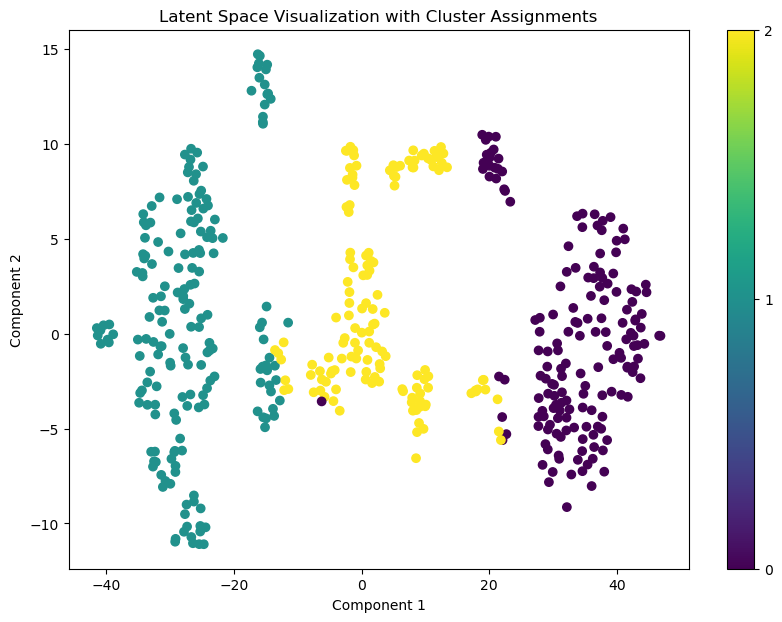

In [35]:
# Cell X: Visualize Latent Space with Cluster Labels
import matplotlib.pyplot as plt

# Assuming 'latent_2d' is obtained from t-SNE transformation
# If not already done, perform t-SNE:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_features)

# Plotting
plt.figure(figsize=(10, 7))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter, ticks=range(num_clusters))
plt.title('Latent Space Visualization with Cluster Assignments')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


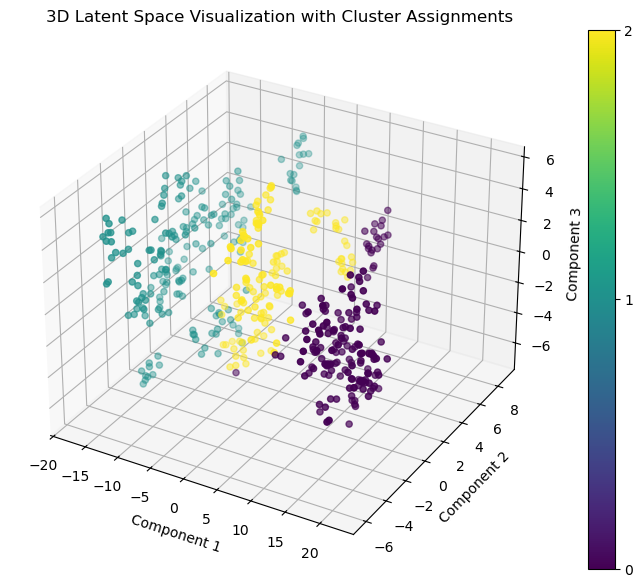

In [36]:
# Reduce dimensionality to 3D
tsne_3d = TSNE(n_components=3, random_state=42)
latent_3d = tsne_3d.fit_transform(latent_features)

# Plotting in 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter, ticks=range(num_clusters))
ax.set_title('3D Latent Space Visualization with Cluster Assignments')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()


In [44]:
# Cell 8.1: Save the Model in HDF5 Format
# Ensure the directory exists
import os

checkpoint_dir = 'checkpoints_03'
os.makedirs(checkpoint_dir, exist_ok=True)

# Save the full autoencoder model
autoencoder.save(os.path.join(checkpoint_dir, 'final_autoencoder_model.h5'))





In [45]:
import h5py

model_path = os.path.join(checkpoint_dir, 'final_autoencoder_model.h5')

with h5py.File(model_path, 'r') as f:
    print("Keys:", list(f.keys()))
    # Should output something like: Keys: ['layer_names', 'model_weights', 'model_config', ...]


Keys: ['model_weights', 'optimizer_weights']


In [38]:
# Cell 8.2: Load the Model
from tensorflow.keras.models import load_model

# Define the checkpoint directory and file paths
checkpoint_dir = 'checkpoints_03'

# Load the autoencoder model
autoencoder = load_model(os.path.join(checkpoint_dir, 'final_autoencoder_model.keras'))

# Load the encoder model
encoder = load_model(os.path.join(checkpoint_dir, 'encoder_model.keras'))


Convert for further use

In [39]:
pip install tensorflowjs


Note: you may need to restart the kernel to use updated packages.


In [47]:
import tensorflowjs as tfjs


Conversion

In [48]:
# Ensure the checkpoint directory exists
import os

checkpoint_dir = 'checkpoints_03'
tfjs_target_dir = os.path.join(checkpoint_dir, 'tfjs_model')
os.makedirs(tfjs_target_dir, exist_ok=True)

# Import TensorFlow.js module
import tensorflowjs as tfjs

# Save the autoencoder model directly to TensorFlow.js format
tfjs.converters.save_keras_model(autoencoder, tfjs_target_dir)

print(f"Model saved to {tfjs_target_dir}")


failed to lookup keras version from the file,
    this is likely a weight only file
Model saved to checkpoints_03/tfjs_model


In [49]:
import numpy as np
import json

# Assuming `training_data` is a NumPy array of shape (num_samples, num_features)
# Replace this with your actual training data
training_data = np.random.rand(1000, 13)  # Example data with 13 MFCC coefficients

# Calculate mean and standard deviation for each feature
data_mean = np.mean(training_data, axis=0).tolist()
data_std = np.std(training_data, axis=0).tolist()

# Create a dictionary to hold the normalization parameters
norm_params = {
    "dataMean": data_mean,
    "dataStd": data_std
}

# Save to norm_params.json
with open('norm_params.json', 'w') as f:
    json.dump(norm_params, f, indent=4)

print("norm_params.json has been created successfully.")


norm_params.json has been created successfully.
